<a href="https://colab.research.google.com/github/malavineha/waste-management-system/blob/main/solid_waste_classifiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile

with zipfile.ZipFile('archive-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')


In [10]:
import os
import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Path to the original dataset
source_dir = "/content/dataset/Garbage classification/Garbage classification"

# Step 1: Delete the 'trash' folder if it exists
trash_path = os.path.join(source_dir, 'trash')
if os.path.exists(trash_path):
    shutil.rmtree(trash_path)
    print("✅ Deleted 'trash' folder.")
else:
    print("ℹ️ 'trash' folder not found. Skipping deletion.")

# Step 2: Define valid classes and output paths
target_classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
output_dir = "/content/clean_split_dataset"
train_ratio = 0.8

# Create train/val folders
for split in ['train', 'val']:
    for cls in target_classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# Step 3: Split and copy images
for cls in target_classes:
    class_path = os.path.join(source_dir, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    split_idx = int(len(images) * train_ratio)
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Copy training images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(output_dir, 'train', cls, img)
        shutil.copy2(src, dst)

    # Copy validation images
    for img in val_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(output_dir, 'val', cls, img)
        shutil.copy2(src, dst)

print("✅ Dataset successfully split into train and val sets.")


✅ Deleted 'trash' folder.
✅ Dataset successfully split into train and val sets.


In [11]:
# Only run this in Colab
!pip install -q tensorflow


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os


In [13]:
# Paths to train and validation directories
train_dir = "clean_split_dataset/train"
val_dir = "clean_split_dataset/val"

# Basic settings
img_size = (300, 300)  # Required for EfficientNetB3
batch_size = 32
num_classes = 5


In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1910 images belonging to 5 classes.
Found 480 images belonging to 5 classes.


In [15]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=img_size + (3,))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [17]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 758s 12s/step - accuracy: 0.1956 - loss: 1.6439 - val_accuracy: 0.2479 - val_loss: 1.6003
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 709s 12s/step - accuracy: 0.2267 - loss: 1.6186 - val_accuracy: 0.2479 - val_loss: 1.5969
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 717s 12s/step - accuracy: 0.2452 - loss: 1.6176 - val_accuracy: 0.2479 - val_loss: 1.5934
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 719s 12s/step - accuracy: 0.2408 - loss: 1.6042 - val_accuracy: 0.2479 - val_loss: 1.5902
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 702s 12s/step - accuracy: 0.2414 - loss: 1.6132 - val_accuracy: 0.2479 - val_loss: 1.5871
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 708s 12s/step - accuracy: 0.2224 - loss: 1.6053 - val_accuracy: 0.2479 - val_loss: 1.5841
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 701s 12s/step - accuracy: 0.2604 - loss: 1.5965 - val_accuracy: 0.2479 - val_loss: 1.5809
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 697s 12s/step - accuracy: 0.2505 - loss: 1.5854 - val_accuracy: 0.

In [18]:
# Unfreeze and fine-tune top layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 842s 14s/step - accuracy: 0.2497 - loss: 1.5855 - val_accuracy: 0.3042 - val_loss: 1.5779
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 798s 13s/step - accuracy: 0.2721 - loss: 1.5619 - val_accuracy: 0.2896 - val_loss: 1.5779
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 801s 13s/step - accuracy: 0.2514 - loss: 1.5660 - val_accuracy: 0.2875 - val_loss: 1.5747
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 872s 15s/step - accuracy: 0.2932 - loss: 1.5388 - val_accuracy: 0.2875 - val_loss: 1.5675
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 803s 13s/step - accuracy: 0.2819 - loss: 1.5642 - val_accuracy: 0.2958 - val_loss: 1.5511


15/15 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step
📊 Classification Report:

              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        81
       glass       0.25      0.95      0.39       101
       metal       0.00      0.00      0.00        82
       paper       0.52      0.39      0.44       119
     plastic       0.00      0.00      0.00        97

    accuracy                           0.30       480
   macro avg       0.15      0.27      0.17       480
weighted avg       0.18      0.30      0.19       480



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


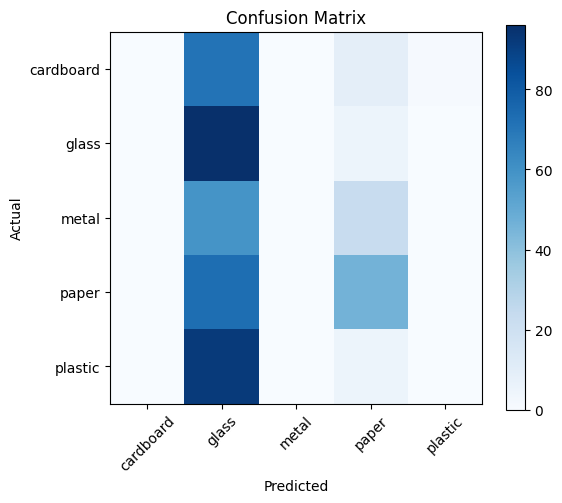

In [19]:
# Predict
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Metrics
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [20]:
model.save("efficientnet_waste_classifier.h5")
print("✅ Model saved as efficientnet_waste_classifier.h5")


✅ Model saved as efficientnet_waste_classifier.h5


In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Define class labels (in the same order used during training)
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

# Load and preprocess the image
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # Match model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale as used during training

    # Predict
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
    plt.show()

    return predicted_class, confidence


In [26]:
# Class label to number mapping
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
label_to_number = {label: i + 1 for i, label in enumerate(class_labels)}


In [27]:
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(300, 300))  # Match model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_labels[predicted_index]
    predicted_number = label_to_number[predicted_label]
    confidence = np.max(predictions[0])

    # Show image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Class Number: {predicted_number} ({confidence*100:.2f}%)")
    plt.show()

    return predicted_number, confidence



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


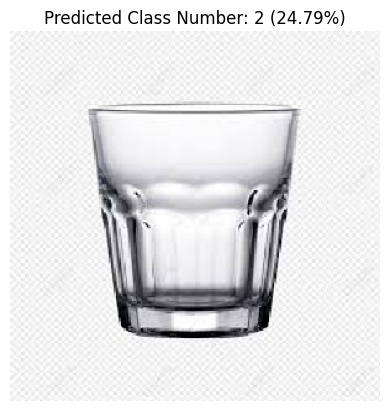

🔢 Predicted Class Number: 2, Confidence: 24.79%


In [28]:
img_path = '/content/glass.jpg'  # replace with your image path
predicted_number, confidence = predict_image(img_path, model)
print(f"🔢 Predicted Class Number: {predicted_number}, Confidence: {confidence*100:.2f}%")


In [29]:
model.save("waste_classifier_model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')